In [116]:
import os

DIR = "data/fungi_train_val"
filelist = []

for cat in os.listdir(DIR):
    for img in os.listdir(DIR + "/" + cat):
        filelist.append({'path': DIR + "/" + cat + "/" + img, 'training': 1})
        
print("Categories:", len(os.listdir(DIR)))
print("Elements:", len(filelist))

Categories: 1394
Elements: 89760


In [103]:
import random

training_size = 0.9

while len(val_set_indexes) <= int(len(filelist)*(1-training_size)):
    rand = random.randint(0, len(filelist)-1)
    if rand not in val_set_indexes:
        val_set_indexes.append(rand)

for i in range(len(filelist)):
    if i in val_set_indexes:
        filelist[i]['training'] = 0
    else:
        filelist[i]['training'] = 1
        
training_set = list(filter(lambda x: x['training'] == 1, filelist))
validation_set = list(filter(lambda x: x['training'] == 0, filelist))

print("Training set:", len(training_set))
print("Validation set:", len(validation_set))

Training set: 81216
Validation set: 8544


{'path': 'data/fungi_train_val/12770_Crepidotus_cesatii/TOB2016PIC32166426.JPG', 'training': 1}


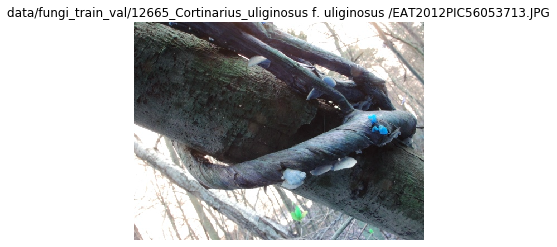

In [129]:
import cv2 
import matplotlib.pyplot as plt

choosen = random.randint(0, len(filelist)-1)
print(filelist[choosen])

img = cv2.imread(filelist[choosen]['path'])  
plt.title(filelist[0]['path'])
plt.grid(False)
plt.axis('off')
plt.imshow(img)
plt.show()

In [127]:
import json

with open('data/train.json') as f:
  data = json.load(f)

print(data['annotations'][:3])

[{'id': 43829, 'category_id': 650, 'image_id': 21942}, {'id': 44039, 'category_id': 650, 'image_id': 21943}, {'id': 44255, 'category_id': 650, 'image_id': 21944}]
